In [5]:
import os
for dirname, _, filenames in os.walk('./'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./product_hierarchy.csv
./sales.csv
./sales_forecast.ipynb
./store_cities.csv
./.ipynb_checkpoints\sales_forecast-checkpoint.ipynb


In [16]:
import pandas as pd
import time
import datetime
import sklearnex
import xgboost as xgb
from sklearnex.model_selection import train_test_split

#Intel(R) Extension for Scikit-learn dynamically patches scikit-learn estimators to use oneDAL as the underlying solver
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [7]:
sales = pd.read_csv("./sales.csv")
sales.head()

C:\Users\debaj\AppData\Local\Temp\ipykernel_17880\3190580931.py:1: DtypeWarning: Columns (10,12) have mixed types. Specify dtype option on import or set low_memory=False.
  sales = pd.read_csv("./sales.csv")


,product_id,store_id,date,sales,revenue,stock,price,promo_type_1,promo_bin_1,promo_type_2,promo_bin_2,promo_discount_2,promo_discount_type_2
0,P0001,S0002,2017-01-02,0.0,0.00,8.0,6.25,PR14,NaN,PR03,NaN,NaN,NaN
1,P0001,S0012,2017-01-02,1.0,5.30,0.0,6.25,PR14,NaN,PR03,NaN,NaN,NaN
2,P0001,S0013,2017-01-02,2.0,10.59,0.0,6.25,PR14,NaN,PR03,NaN,NaN,NaN
3,P0001,S0023,2017-01-02,0.0,0.00,6.0,6.25,PR14,NaN,PR03,NaN,NaN,NaN
4,P0001,S0025,2017-01-02,0.0,0.00,1.0,6.25,PR14,NaN,PR03,NaN,NaN,NaN


In [9]:
len(sales)

19454838

In [10]:
sales.isnull().sum()

product_id                      0
store_id                        0
date                            0
sales                     1190762
revenue                   1190762
stock                     1190762
price                      571981
promo_type_1                    0
promo_bin_1              16803149
promo_type_2                    0
promo_bin_2              19395757
promo_discount_2         19395757
promo_discount_type_2    19395757
dtype: int64

In [8]:
sales.columns

Index(['product_id', 'store_id', 'date', 'sales', 'revenue', 'stock', 'price',
       'promo_type_1', 'promo_bin_1', 'promo_type_2', 'promo_bin_2',
       'promo_discount_2', 'promo_discount_type_2'],
      dtype='object')

In [11]:
sales["stock"].describe()

count    1.826408e+07
mean     1.588102e+01
std      3.728009e+01
min      0.000000e+00
25%      4.000000e+00
50%      8.000000e+00
75%      1.700000e+01
max      4.716000e+03
Name: stock, dtype: float64

In [12]:
grouped = sales[["product_id", "stock", "sales"]].groupby("product_id").sum()
most_understocked = grouped[grouped["stock"] == 0].sort_values("sales", ascending = False)
most_understocked.head(5)

,stock,sales
product_id,,
P0561,0.0,2547.042
P0550,0.0,1975.748
P0203,0.0,940.000
P0484,0.0,107.840
P0243,0.0,82.000


In [13]:
grouped = sales[["product_id", "stock", "sales"]].groupby("product_id").sum()
grouped["ogstock_sales_ratio"]=grouped["sales"]/(grouped["sales"]+grouped["stock"])
overstocked = grouped.sort_values("ogstock_sales_ratio", ascending = True)
overstocked.head()

,stock,sales,ogstock_sales_ratio
product_id,,,
P0526,367220.0,197.0,0.000536
P0098,2814.0,2.0,0.000710
P0136,8253.0,6.0,0.000726
P0237,290850.0,245.0,0.000842
P0161,136247.0,117.0,0.000858


In [14]:
import matplotlib.pyplot as plt
head = 5
fig, axs = plt.subplots(head)
grouped["ogstock_sales_ratio"]=grouped["sales"]/(grouped["sales"]+grouped["stock"])

overstocked_items_by_ratio = grouped.sort_values("ogstock_sales_ratio", ascending = True)
overstocked_items_by_ratio.head(head)
overstocked_items_by_ratio = list(overstocked_items_by_ratio[0:head].index)

for i, item in enumerate(overstocked_items_by_ratio):
    ax = axs[i]
    sales[sales["product_id"] == item][["date","sales", "stock"]].plot.line(x="date", y="stock", ax=ax)
    sales[sales["product_id"] == item][["date","sales", "stock"]].plot.line(x="date", y="sales", ax=ax)
    ax.set_ylim([0, 1000])
    ax.set_yscale('symlog')
    ax.set_label(item)
fig.set_size_inches([15, 5*head])
plt.savefig("./timeseries_overstocked_ratio.png")
#plt.show()

plt.clf()
overstocked_items_by_ratio = grouped.sort_values("stock", ascending = False)
overstocked_items_by_ratio.head(head)
overstocked_items_by_ratio = list(overstocked_items_by_ratio[0:head].index)

for i, item in enumerate(overstocked_items_by_ratio):
    ax = axs[i]
    sales[sales["product_id"] == item][["date","sales", "stock"]].plot.line(x="date", y="stock", ax=ax)
    sales[sales["product_id"] == item][["date","sales", "stock"]].plot.line(x="date", y="sales", ax=ax)
    ax.set_ylim([0, 1000])
    ax.set_yscale('symlog')
    ax.set_label(item)
fig.set_size_inches([15, 5*head])
plt.savefig("./timeseries_overstocked_abs.png")
#plt.show()

<Figure size 1080x1800 with 0 Axes>

<Figure size 432x288 with 0 Axes>

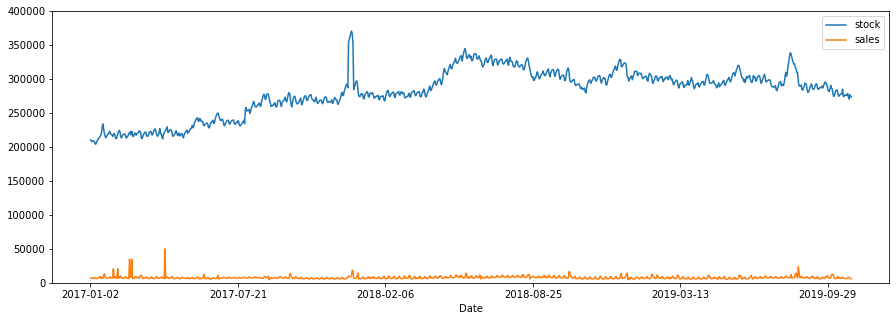

In [15]:
from matplotlib.ticker import StrMethodFormatter

plt.clf()
grouped_day = sales[["date", "sales", "stock"]].groupby("date").sum()
grouped_day_cleaned = grouped_day[:-59]
fig, ax = plt.subplots()
grouped_day_cleaned.plot.line(y="stock", ax=ax)
grouped_day_cleaned.plot.line(y="sales", ax=ax)
ax.set_ylim([0, 4e5])
#ax.set_yscale('symlog')
ax.set_label("Total stock vs sales")
ax.set_xlabel("Date")
#ax.xaxis.set_major_formatter(StrMethodFormatter('%[-2:]'))
fig.set_size_inches([15, 5])
plt.savefig("./timeseries_overstocked_all_lin.png")
plt.show()

In [17]:
sales.head()

,product_id,store_id,date,sales,revenue,stock,price,promo_type_1,promo_bin_1,promo_type_2,promo_bin_2,promo_discount_2,promo_discount_type_2
0,P0001,S0002,2017-01-02,0.0,0.00,8.0,6.25,PR14,NaN,PR03,NaN,NaN,NaN
1,P0001,S0012,2017-01-02,1.0,5.30,0.0,6.25,PR14,NaN,PR03,NaN,NaN,NaN
2,P0001,S0013,2017-01-02,2.0,10.59,0.0,6.25,PR14,NaN,PR03,NaN,NaN,NaN
3,P0001,S0023,2017-01-02,0.0,0.00,6.0,6.25,PR14,NaN,PR03,NaN,NaN,NaN
4,P0001,S0025,2017-01-02,0.0,0.00,1.0,6.25,PR14,NaN,PR03,NaN,NaN,NaN


In [18]:
sales.shape

(19454838, 13)

In [19]:
#Checking the datatypes of different columns of the data
sales.dtypes

product_id                object
store_id                  object
date                      object
sales                    float64
revenue                  float64
stock                    float64
price                    float64
promo_type_1              object
promo_bin_1               object
promo_type_2              object
promo_bin_2               object
promo_discount_2         float64
promo_discount_type_2     object
dtype: object

In [20]:
# Creating column's subsets as per the datatype

sales_dtypes = sales.dtypes.reset_index()
sales_dtypes.columns = ['variable', 'dtype']

# Getting the categorical columns
cat_cols = sales_dtypes[sales_dtypes['dtype']=='object']['variable'].tolist()

# Getting the continuos columns
cont_cols = sales_dtypes[sales_dtypes['dtype']!='object']['variable'].tolist()

print("Categorical Columns:", cat_cols)
print()
print("Continuos Columns:", cont_cols)

Categorical Columns: ['product_id', 'store_id', 'date', 'promo_type_1', 'promo_bin_1', 'promo_type_2', 'promo_bin_2', 'promo_discount_type_2']

Continuos Columns: ['sales', 'revenue', 'stock', 'price', 'promo_discount_2']


In [21]:
# Descriptive statistics include those that summarize the count, unique and top category freq of a dataset’s distribution.
sales[cat_cols].describe().T


,count,unique,top,freq
product_id,19454838,649,P0125,140997
store_id,19454838,144,S0038,356019
date,19454838,1092,2019-08-10,20945
promo_type_1,19454838,17,PR14,16803149
promo_bin_1,2651689,5,verylow,1117148
promo_type_2,19454838,4,PR03,19395757
promo_bin_2,59081,4,verylow,30577
promo_discount_type_2,59081,4,PR02,33184


In [22]:
# Descriptive statistics include those that summarize the central tendency, dispersion and shape of a dataset’s distribution.
sales[cont_cols].describe(percentiles=[.05,.25,.50,.75,.95]).round(2).T

,count,mean,std,min,5%,25%,50%,75%,95%,max
sales,18264076.0,0.44,14.66,0.00,0.0,0.00,0.00,0.0,2.00,43301.00
revenue,18264076.0,2.06,39.90,0.00,0.0,0.00,0.00,0.0,10.93,84197.96
stock,18264076.0,15.88,37.28,0.00,1.0,4.00,8.00,17.0,48.00,4716.00
price,18882857.0,15.58,32.30,0.01,1.0,3.35,7.95,16.9,53.90,1599.00
promo_discount_2,59081.0,25.52,11.06,10.00,10.0,19.00,20.00,33.0,50.00,50.00


In [23]:
# Function to get categorical column volumetric analysis

def get_volumetric(sales, col):
    '''
    This function gives the volumetric analysis of the categorical 
    column of the dataset.
    
    Parameters
    ----------
    dataset: name of the dataset
    columns: column labels to use from the dataframe
    
    Returns
    -------
    Gives percentage volume of different category for each column.
    
    -------------------------------------------------------------------------------------
    '''
    col_volumetric = sales[col].value_counts(dropna=False).reset_index()
    col_volumetric.columns = [col, 'volume']
    col_volumetric['%volume'] = ((col_volumetric['volume']*100)/col_volumetric['volume'].sum()).round(2)
    return col_volumetric

In [24]:
# Getting the category volume distribution and cardinality
for col in cat_cols:
    cat_volumteric_t = get_volumetric(sales, col)
    print(col)
    print(f"Unique Category preset: {cat_volumteric_t.shape[0]}")
    display(cat_volumteric_t)
    print()


product_id
Unique Category preset: 649


,product_id,volume,%volume
0,P0125,140997,0.72
1,P0364,140569,0.72
2,P0261,139651,0.72
3,P0333,139632,0.72
4,P0664,139486,0.72
...,...,...,...
644,P0618,94,0.00
645,P0578,64,0.00
646,P0243,63,0.00
647,P0384,22,0.00



store_id
Unique Category preset: 144


,store_id,volume,%volume
0,S0038,356019,1.83
1,S0085,346267,1.78
2,S0115,301266,1.55
3,S0097,296700,1.53
4,S0094,293377,1.51
...,...,...,...
139,S0134,19723,0.10
140,S0057,19546,0.10
141,S0007,18346,0.09
142,S0136,17231,0.09



date
Unique Category preset: 1092


,date,volume,%volume
0,2019-08-10,20945,0.11
1,2019-08-17,20897,0.11
2,2019-06-15,20889,0.11
3,2019-06-22,20887,0.11
4,2019-06-01,20851,0.11
...,...,...,...
1087,2017-01-03,13108,0.07
1088,2017-01-08,13096,0.07
1089,2017-01-05,13093,0.07
1090,2017-01-04,13087,0.07



promo_type_1
Unique Category preset: 17


,promo_type_1,volume,%volume
0,PR14,16803149,86.37
1,PR05,1163574,5.98
2,PR10,457759,2.35
3,PR03,312942,1.61
4,PR06,274782,1.41
5,PR07,139452,0.72
6,PR12,85846,0.44
7,PR09,78697,0.40
8,PR17,70442,0.36
9,PR01,30426,0.16



promo_bin_1
Unique Category preset: 6


,promo_bin_1,volume,%volume
0,NaN,16803149,86.37
1,verylow,1117148,5.74
2,low,551829,2.84
3,moderate,418880,2.15
4,high,308607,1.59
5,veryhigh,255225,1.31



promo_type_2
Unique Category preset: 4


,promo_type_2,volume,%volume
0,PR03,19395757,99.70
1,PR02,44005,0.23
2,PR04,8315,0.04
3,PR01,6761,0.03



promo_bin_2
Unique Category preset: 5


,promo_bin_2,volume,%volume
0,NaN,19395757,99.70
1,verylow,30577,0.16
2,low,11417,0.06
3,high,9987,0.05
4,veryhigh,7100,0.04



promo_discount_type_2
Unique Category preset: 5


,promo_discount_type_2,volume,%volume
0,NaN,19395757,99.70
1,PR02,33184,0.17
2,PR01,14991,0.08
3,PR04,5971,0.03
4,PR03,4935,0.03


In [25]:
#Removing the columns with imbalanced distribution of data 
sales = sales.drop(['promo_bin_1',
                    'promo_bin_2',
                    'promo_discount_2',
                    'promo_discount_type_2',
                    'promo_type_1',
                    'promo_type_2'], 
                    axis=1)

In [26]:
sales.head()


,product_id,store_id,date,sales,revenue,stock,price
0,P0001,S0002,2017-01-02,0.0,0.00,8.0,6.25
1,P0001,S0012,2017-01-02,1.0,5.30,0.0,6.25
2,P0001,S0013,2017-01-02,2.0,10.59,0.0,6.25
3,P0001,S0023,2017-01-02,0.0,0.00,6.0,6.25
4,P0001,S0025,2017-01-02,0.0,0.00,1.0,6.25


In [27]:
#Extracting month, week, day name and year from the date column
sales['month']=pd.to_datetime(sales['date']).dt.month
sales['week']=pd.to_datetime(sales['date']).dt.week
sales['day_name']=pd.to_datetime(sales['date']).dt.day_name()
sales['year']=pd.to_datetime(sales['date']).dt.year
sales.head()

C:\Users\debaj\AppData\Local\Temp\ipykernel_17880\2834123006.py:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  sales['week']=pd.to_datetime(sales['date']).dt.week


,product_id,store_id,date,sales,revenue,stock,price,month,week,day_name,year
0,P0001,S0002,2017-01-02,0.0,0.00,8.0,6.25,1,1,Monday,2017
1,P0001,S0012,2017-01-02,1.0,5.30,0.0,6.25,1,1,Monday,2017
2,P0001,S0013,2017-01-02,2.0,10.59,0.0,6.25,1,1,Monday,2017
3,P0001,S0023,2017-01-02,0.0,0.00,6.0,6.25,1,1,Monday,2017
4,P0001,S0025,2017-01-02,0.0,0.00,1.0,6.25,1,1,Monday,2017


## Modelling

In [28]:
cols_feature = [ 'revenue', 'stock', 'sales', 'month', 'week', 'year']
cols_predict = ['price']

In [29]:
#Extracting month, week, day name and year from the date column
X = sales[cols_feature]
y = sales['price']

In [30]:
#Imputing missing values with zero
X = X.fillna(0)
y=  y.fillna(0)

## Splitting the dataset into train and test data¶


In [31]:
%%time
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.25, random_state = 10)

MemoryError: Unable to allocate 334. MiB for an array with shape (3, 14591129) and data type float64

## Creating an instance of the XGBoost Model

In [32]:
%%time
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

CPU times: total: 0 ns
Wall time: 0 ns


## Model Training

In [33]:
%%time
xg_reg.fit(X_train,y_train)


NameError: name 'X_train' is not defined

In [34]:
%%time
preds = xg_reg.predict(X_valid)

NameError: name 'X_valid' is not defined